In [1]:
from __future__ import division, print_function

import os
import sys
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from archetypes.io import read_parent
from SetCoverPy import setcover, mathutils

%matplotlib inline

In [2]:
# Plotting preferences
#import seaborn as sns
#sns.set(style='white', font_scale=1.4)
#col = sns.color_palette('dark')
mpl.rcParams.update({'font.size': 14})

In [3]:
# Initialize the random seed so the results are reproducible, below.
seed = 123
rand = np.random.RandomState(seed)

In [4]:
# Read the parent sample (already in the restframe). Select a subset of 
# spectra over a limited wavelength range for testing.
objtype = 'ELG'
nspec = 500
wmin, wmax = (3600, 7500)
dwave = 2.0
wave = np.arange(wmin, wmax+dwave/2.0, dwave)
npix = len(wave)
flux, _, meta = read_parent(objtype, outwave=wave, nspec=nspec, seed=seed)
ferr = np.ones_like(flux)
print(flux.shape, ferr.shape, wave.shape, nspec)

(500, 1951) (500, 1951) (1951,) 500


In [5]:
# Normalize to the median flux around 5500-5550
normflux = flux.copy()
for ii in range(nspec):
    ww = np.where((wave>5500)*(wave<5550))[0]
    normflux[ii, :] /= np.median(flux[ii, ww])

[126  47  73  32 430 224 111 409 339 334 253 420  96 208  68 305 311 451
   2 340  39 322  84  47 445]


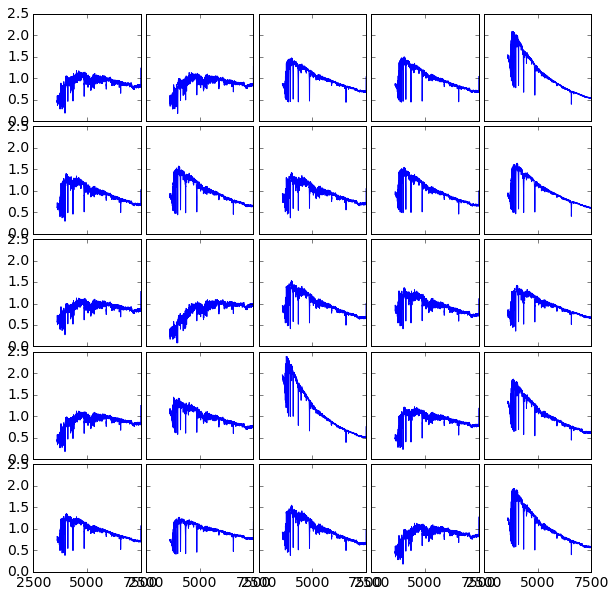

In [25]:
# Plot a random sampling of the parent spectra.
nrow, ncol = (5, 5)
nplot = nrow*ncol
these = rand.choice(nspec, nplot)
print(these)
fig, ax = plt.subplots(nrow, ncol, figsize=(2*ncol, 2*nrow), sharey=True, sharex=True)
for thisax, indx in zip(ax.flat, these):
    thisax.plot(wave, normflux[indx, :])
    thisax.xaxis.set_major_locator(plt.MaxNLocator(2))
fig.subplots_adjust(wspace=0.05, hspace=0.05)

In [7]:
# Compute chi2 as our "distance" matrix.
chi2 = np.zeros((nspec, nspec))
amp = np.zeros((nspec, nspec))
for ii in range(nspec):
    xx = normflux[ii, :].reshape(1, npix)
    xxerr = ferr[ii, :].reshape(1, npix)
    amp1, chi21 = mathutils.quick_amplitude(xx, normflux, xxerr, ferr)
    chi2[ii, :] = chi21
    amp[ii, :] = amp1
#chi2 /= (nspec-1.0) # reduced chi^2?!?

In [8]:
print(chi2)

[[  0.           3.29928121  20.15879126 ...,   5.05629835  55.10766896
   43.48176337]
 [  3.29962601   0.           8.64636041 ...,   1.50567028  31.76523045
   22.91904761]
 [ 20.18586137   8.64896668   0.         ...,   5.65394465  10.03405282
    8.18846038]
 ..., 
 [  5.05705816   1.50566584   5.65276821 ...,   0.          29.32018533
   23.07823651]
 [ 55.41353882  31.83449043  10.03744085 ...,  29.38087346   0.
    1.69090514]
 [ 43.6638824   22.95284743   8.19043213 ...,  23.11355369   1.69089302
    0.        ]]


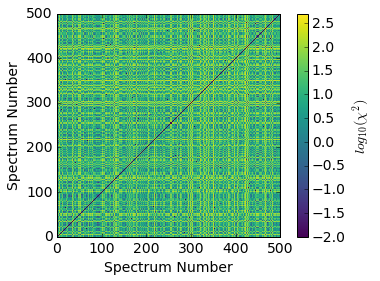

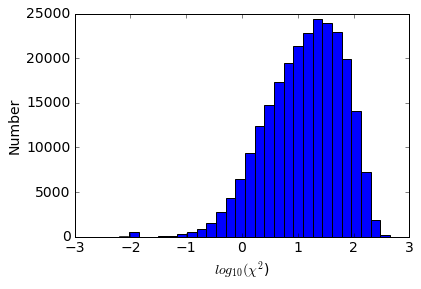

In [9]:
# Need to figure out what chi^2 minimum to choose.
_chi2 = chi2
_chi2[chi2 == 0] = 0.01
plt.figure()
plt.imshow(np.log10(_chi2), origin='lower', interpolation='nearest', 
           vmin=-2.0, cmap='viridis')
plt.xlabel('Spectrum Number')
plt.ylabel('Spectrum Number')
plt.colorbar(label='$log_{10}(\chi^{2})$')

plt.figure()
plt.hist(np.log10(_chi2).reshape(nspec*nspec), bins=30, range=(-2.2,3))
plt.ylabel('Number')
plt.xlabel('$log_{10}(\chi^{2}$)')

In [10]:
# If we want the archetypes to describe each spectrum in the parent sample to a precision
# of prec=0.1 (10%) then we we should set chi2min to be approximately npix*prec^2.
prec = 0.1
chi2min = npix*prec**2
print(chi2min, np.log10(chi2min)) # seems high...

19.51 1.29025726939


In [11]:
# Messing around with some chi2min arrays...
print(np.linspace(0.1, 10, 10))
print(np.logspace(-1.0, 1, 10))

[  0.1   1.2   2.3   3.4   4.5   5.6   6.7   7.8   8.9  10. ]
[  0.1          0.16681005   0.27825594   0.46415888   0.77426368
   1.29154967   2.15443469   3.59381366   5.9948425   10.        ]


In [12]:
# Generate a plot of number of archtypes vs chi2 threshold
cost = np.ones(nspec) # uniform cost
chi2min = np.logspace(0.1, 1, 10)
narch = np.zeros_like(chi2min)
for ii, cmin in enumerate(chi2min):
    gg = setcover.SetCover((chi2 <= cmin)*1, cost)
    sol, time = gg.SolveSCP()
    narch[ii] = len(np.nonzero(gg.s)[0])

This Best solution: UB=36.0, LB=-1196.89356473, UB1=36.0, LB1=-1196.89356473
Current Best Solution: UB=36.0, LB=-1196.89356473, change=3424.70434647% @ niters=0
This Best solution: UB=30.0, LB=27.2400463399, UB1=31.0, LB1=27.2414666995
Current Best Solution: UB=30.0, LB=27.2400463399, change=9.19984553376% @ niters=5
This Best solution: UB=36.0, LB=-4102.14798618, UB1=36.0, LB1=-4102.14798618
Current Best Solution: UB=30.0, LB=27.174791982, change=9.41736006005% @ niters=10
This Best solution: UB=30.0, LB=26.8888814163, UB1=30.0, LB1=26.8888814163
Current Best Solution: UB=30.0, LB=26.8888814163, change=10.3703952789% @ niters=15
Iteration in re-initialization reaches maximum number = 20
Current Best Solution: UB=30.0, LB=27.3446992817, change=8.85100239421% @ niters=20
Final Best solution: 30.0
Took 1.168 minutes to reach current solution.
This Best solution: UB=25.0, LB=-1523.5441977, UB1=25.0, LB1=-1523.5441977
Current Best Solution: UB=25.0, LB=-1523.5441977, change=6194.1767908% @

/usr/local/lib/python2.7/site-packages/SetCoverPy/setcover.py:403: UserWarning: Iteration in subgradient reaches maximum = 100
  warnings.warn("Iteration in subgradient reaches maximum = {0}".format(niters))


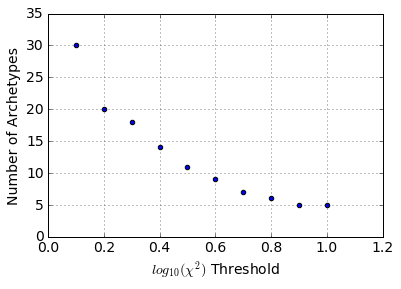

In [13]:
fig, ax = plt.subplots(1, 1)
ax.scatter(np.log10(chi2min), narch)
#ax.semilogx(chi2min, narch, '-o')
ax.set_xlabel('$log_{10}(\chi^{2})$ Threshold')
ax.set_ylabel('Number of Archetypes')
ax.grid(True)

In [14]:
# Function to get the responsibility for a given set of archetypes.
def responsibility(iarch, a_matrix):
    '''iarch : indices of the archetypes'''
    '''a_matrix : distance matrix'''
    narch = len(iarch)
    resp = np.zeros(narch)
    for ii, this in enumerate(iarch):
        resp[ii] = np.count_nonzero(a_matrix[:, this])
    return resp

In [15]:
# Solve the SCP given the preceding results.  Also get the responsibility.
chi2min = 10**0.4
a_matrix = (chi2 <= chi2min)*1
gg = setcover.SetCover(a_matrix, cost)
sol, time = gg.SolveSCP()

This Best solution: UB=18.0, LB=-2598.97781139, UB1=18.0, LB1=-2598.97781139
Current Best Solution: UB=18.0, LB=-2598.97781139, change=14538.7656188% @ niters=0
This Best solution: UB=14.0, LB=11.6482268584, UB1=17.0, LB1=11.7099136639
Current Best Solution: UB=14.0, LB=11.6482268584, change=16.7983795832% @ niters=5
This Best solution: UB=21.0, LB=-12080.2347039, UB1=21.0, LB1=-12080.2347039
Current Best Solution: UB=14.0, LB=11.6482268584, change=16.7983795832% @ niters=10
This Best solution: UB=15.0, LB=11.8432128513, UB1=18.0, LB1=11.8457250935
Current Best Solution: UB=14.0, LB=11.6482268584, change=16.7983795832% @ niters=15
Iteration in re-initialization reaches maximum number = 20
Current Best Solution: UB=14.0, LB=11.6482268584, change=16.7983795832% @ niters=20
Final Best solution: 14.0
Took 1.197 minutes to reach current solution.


In [37]:
# Set the indices of the archetypes, sorted by D(4000)
iarch = np.nonzero(gg.s)[0]
iarch = iarch[np.argsort(meta['D4000'][iarch])]
nnarch = len(iarch)
resp = responsibility(iarch, a_matrix)
print(time, sol, iarch, resp, np.sum(resp)) # sum(resp)>nspec!

1.19680004915 14.0 [451 278 362 475 186 111 442   0 408 287 161 417 461 420] [   1.   13.   31.   39.   78.  141.   26.  127.   87.   79.   56.   49.
   19.    4.] 750.0


In [26]:
meta.columns

<TableColumns names=('TEMPLATEID','OBJNO','RA','DEC','Z','MAGB','MAGR','MAGI','DECAM_G','DECAM_R','DECAM_Z','W1','W2','SIGMA_KMS','OII_3726','OII_3729','OII_3727','OII_3727_EW','OII_CONTINUUM','RADIUS_HALFLIGHT','SERSICN','AXIS_RATIO','LOGMSTAR','LOGSFR','AV_ISM','D4000')>

0.964159 -0.0683098 0.155617 1.0
0.994272 -0.0340614 0.436176 13.0
0.995014 0.235741 0.591 31.0
1.01375 0.326149 0.642467 39.0
1.04577 0.300177 0.869106 78.0
1.08588 0.372469 1.01002 141.0
1.08708 0.160522 0.775225 26.0
1.12287 0.247578 0.99572 127.0
1.13687 0.932634 1.13833 87.0
1.19242 0.672174 1.37357 79.0
1.2617 0.85095 1.27816 56.0
1.28596 0.677465 1.53109 49.0
1.31562 0.848787 1.55751 19.0
1.58068 2.0683 1.9011 4.0


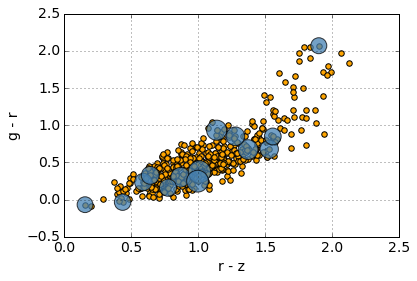

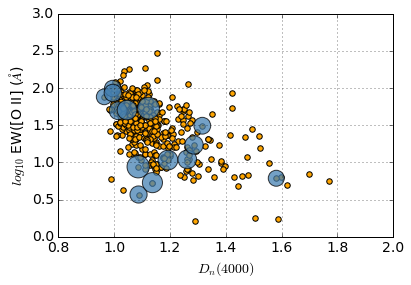

In [41]:
# Generate a color-color plot with the symbol size scaled by the responsibility.
gr = meta['DECAM_G']-meta['DECAM_R']
rz = meta['DECAM_R']-meta['DECAM_Z']
d4000 = meta['D4000']
ewoii = np.log10(meta['OII_3727_EW'])

for dd1, gr1, rz1, r1 in zip(d4000[iarch], gr[iarch], rz[iarch], resp):
    print(dd1, gr1, rz1, r1)
size = 250*(1+(resp - resp.min()) / resp.ptp())
col = plt.cm.coolwarm(size)

fig, ax = plt.subplots()
ax.scatter(rz, gr, s=30, c='orange')
ax.scatter(rz[iarch], gr[iarch], c='steelblue', marker='o', s=size, alpha=0.75)
ax.set_xlabel('r - z')
ax.set_ylabel('g - r')
ax.grid(True)

fig, ax = plt.subplots()
ax.scatter(d4000, ewoii, s=30, c='orange')
ax.scatter(d4000[iarch], ewoii[iarch], c='steelblue', marker='o', s=size, alpha=0.75)
ax.set_xlabel('$D_{n}(4000)$')
ax.set_ylabel('$log_{10}$ EW([O II] ($\AA$)')
ax.grid(True)

451 0.964159
278 0.994272
362 0.995014
475 1.01375
186 1.04577
111 1.08588
442 1.08708
0 1.12287
408 1.13687
287 1.19242
161 1.2617
417 1.28596
461 1.31562
420 1.58068


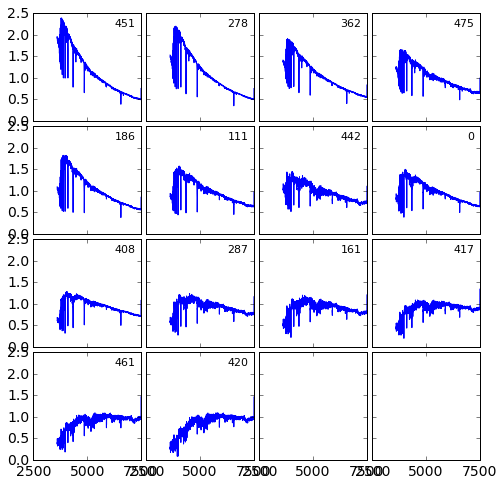

In [50]:
# Plot the archetypes.  Some of them look pretty similar...
nrow, ncol = (4, 4)
nplot = nrow*ncol
fig, ax = plt.subplots(nrow, ncol, figsize=(2*ncol, 2*nrow), sharey=True, sharex=True)
for thisax, indx in zip(ax.flat, iarch):
    thisax.plot(wave, normflux[indx, :])
    thisax.xaxis.set_major_locator(plt.MaxNLocator(2))
    thisax.text(0.95, 0.88, '{}'.format(indx), ha='right', 
             transform=thisax.transAxes, fontsize=11)
    print(indx, meta['D4000'][indx])
fig.subplots_adjust(wspace=0.05, hspace=0.05)